In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import Audio
import numpy as np
import pandas as pd
import pickle
import yaml

from lib import utils
from lib.notebooks import plot_groups_metrics
from imitative_agent import ImitativeAgent

current path: /mnt/c/Users/vpaul/OneDrive - CentraleSupelec/Inner_Speech/agent/imitative_agent_inner_speech_silent_finetune


In [2]:
NB_TRAINING = 5
JERK_LOSS_WEIGHTS = [0.1, 0.15]

In [ ]:
import glob
import pickle
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define metrics to analyze
metrics_name = ["inverse_model_jerk", "inverse_model_repetition_error", "inverse_model_estimation_error"]
groups_metrics = {metric: {} for metric in metrics_name}

# Define the path to agent directories
agents_path = glob.glob("../out/imitative_agent_inner_speech_silent_finetune_nojerk7/*/")
agents_path.sort()

def extract_model_name(agent_path):
    """
    Extract a human-readable model identifier from the full path.
    
    Args:
        agent_path (str): Full path to model directory
        
    Returns:
        str: Clean model name for display
    """
    return os.path.basename(os.path.normpath(agent_path))

# Collect and process metrics across all models
print("Processing metrics for", len(agents_path), "models...")

for agent_path in agents_path:
    try:
        # Load stored metrics
        with open(os.path.join(agent_path, "metrics.pickle"), "rb") as f:
            metrics = pickle.load(f)
    except FileNotFoundError:
        print(f"metrics.pickle not found in {agent_path}. Skipping.")
        continue
    except Exception as e:
        print(f"Error loading metrics from {agent_path}: {e}. Skipping.")
        continue

    # Ensure required keys exist in the metrics dictionary
    if "validation" not in metrics or "test" not in metrics:
        print(f"Required keys missing in metrics from {agent_path}. Skipping.")
        continue

    # Find the index of the best epoch based on inverse_model_repetition_error
    try:
        validation_errors = metrics["validation"]["inverse_model_repetition_error"]
        final_loss_index = np.argmin(validation_errors)
    except KeyError:
        print(f"inverse_model_repetition_error not found in validation metrics for {agent_path}. Skipping.")
        continue
    except Exception as e:
        print(f"Error processing validation metrics for {agent_path}: {e}. Skipping.")
        continue

    # Extract and store test metrics for the best epoch
    for metric_name in metrics_name:
        try:
            agent_metric = metrics["test"][metric_name][final_loss_index]
        except KeyError:
            print(f"{metric_name} not found in test metrics for {agent_path}. Skipping this metric.")
            continue
        except IndexError:
            print(f"Index {final_loss_index} out of range for {metric_name} in {agent_path}. Skipping this metric.")
            continue
        except Exception as e:
            print(f"Error extracting {metric_name} for {agent_path}: {e}. Skipping this metric.")
            continue

        model_name = extract_model_name(agent_path)
        if model_name not in groups_metrics[metric_name]:
            groups_metrics[metric_name][model_name] = []
        groups_metrics[metric_name][model_name].append(agent_metric)

# Convert the grouped metrics into a pandas DataFrame for easier plotting
data = []
for metric, models in groups_metrics.items():
    for model, values in models.items():
        # Calculate mean and standard deviation for each model-metric pair
        mean_val = np.mean(values)
        std_val = np.std(values)
        data.append({
            "Metric": metric,
            "Model": model,
            "Mean": mean_val,
            "Std": std_val
        })

df = pd.DataFrame(data)

# Initialize the Plotly figure
fig = go.Figure()

# Add a trace for each metric
for metric in metrics_name:
    metric_data = df[df["Metric"] == metric]
    fig.add_trace(
        go.Bar(
            x=metric_data["Model"],
            y=metric_data["Mean"],
            name=metric.replace("_", " ").title(),
            error_y=dict(
                type='data',
                array=metric_data["Std"],
                visible=True,
                thickness=1.5,
                width=3
            ),
            hovertemplate=(
                '<b>Model:</b> %{x}<br>' +
                '<b>Mean:</b> %{y:.3f}<br>' +
                '<b>Std Dev:</b> %{error_y.array:.3f}<br>' +
                '<extra></extra>'
            )
        )
    )

# Update layout for interactivity and aesthetics
fig.update_layout(
    title={
        'text': "Model Performance Comparison Across Metrics",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    xaxis_title="Model Architecture",
    yaxis_title="Performance Metric Value",
    barmode='group',
    template='plotly_white',
    legend_title="Metrics",
    font=dict(
        family="Arial, sans-serif",
        size=14
    ),
    margin=dict(l=60, r=60, t=100, b=60),
    height=800,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

# Add interactive metric selection dropdown
buttons = [dict(
    label="All Metrics",
    method="update",
    args=[{"visible": [True]*len(metrics_name)},
          {"title": "Model Performance Comparison Across Metrics"}]
)]

for metric in metrics_name:
    visibility = [m == metric for m in metrics_name]
    buttons.append(dict(
        label=metric.replace("_", " ").title(),
        method="update",
        args=[
            {"visible": visibility},
            {"title": f"Performance: {metric.replace('_', ' ').title()}"}
        ]
    ))

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.0,
        y=1.15,
        xanchor='left',
        yanchor='top',
        showactive=True
    )]
)

# Adjust x-axis labels for better readability
fig.update_xaxes(tickangle=45)

# Show the interactive plot
fig.show()

# Save high-resolution version for publication
#fig.write_html("model_performance_comparison.html")


Processing metrics for 30 models...
221ef425ed39aae2095ac359cca74959-0 - inverse_model_jerk: 2.619 ± 0.000
221ef425ed39aae2095ac359cca74959-1 - inverse_model_jerk: 2.252 ± 0.000
221ef425ed39aae2095ac359cca74959-10 - inverse_model_jerk: 2.474 ± 0.000
221ef425ed39aae2095ac359cca74959-11 - inverse_model_jerk: 8.215 ± 0.000
221ef425ed39aae2095ac359cca74959-12 - inverse_model_jerk: 4.689 ± 0.000
221ef425ed39aae2095ac359cca74959-13 - inverse_model_jerk: 3.183 ± 0.000
221ef425ed39aae2095ac359cca74959-14 - inverse_model_jerk: 3.561 ± 0.000
221ef425ed39aae2095ac359cca74959-15 - inverse_model_jerk: 3.648 ± 0.000
221ef425ed39aae2095ac359cca74959-16 - inverse_model_jerk: 2.647 ± 0.000
221ef425ed39aae2095ac359cca74959-17 - inverse_model_jerk: 2.707 ± 0.000
221ef425ed39aae2095ac359cca74959-18 - inverse_model_jerk: 2.919 ± 0.000
221ef425ed39aae2095ac359cca74959-19 - inverse_model_jerk: 7.285 ± 0.000
221ef425ed39aae2095ac359cca74959-2 - inverse_model_jerk: 3.255 ± 0.000
221ef425ed39aae2095ac359cca7495

In [20]:
# Define metrics to evaluate model performance
metrics_name = ["inverse_model_jerk", "inverse_model_repetition_error", "inverse_model_estimation_error"]

# Initialize dictionary to store metrics for each model group
# Structure: {metric_name: {agent_path: [metric_values]}}
groups_metrics = { metric_name: {} for metric_name in metrics_name }

# Get paths to all trained agent models and sort them for consistent processing
agents_path = glob.glob("../out/imitative_agent_inner_speech_silent_finetune_nojerk7/*/")
agents_path.sort()

# Process metrics for each agent model
for agent_path in agents_path:
    # Load stored metrics from pickle file
    with open("%s/metrics.pickle" % agent_path, "rb") as f:
        metrics = pickle.load(f)

    # Find index of best model based on validation repetition error
    # This ensures we evaluate the model at its optimal performance point
    final_loss_index = np.argmin(metrics["validation"]["inverse_model_repetition_error"])

    # Extract test metrics at the optimal model checkpoint
    for metric_name in metrics_name:
        # Initialize list for this agent if not already present
        if agent_path not in groups_metrics[metric_name]:
            groups_metrics[metric_name][agent_path] = []
            
        # Store test metric value at the optimal checkpoint
        agent_metric = metrics["test"][metric_name][final_loss_index]
        groups_metrics[metric_name][agent_path].append(agent_metric)

Group: 221ef425ed39aae2095ac359cca74959-0
Mean inverse_model_jerk: 2.6190
Mean inverse_model_repetition_error: 4.5609

Group: 221ef425ed39aae2095ac359cca74959-1
Mean inverse_model_jerk: 2.2521
Mean inverse_model_repetition_error: 4.5586

Group: 221ef425ed39aae2095ac359cca74959-10
Mean inverse_model_jerk: 2.4742
Mean inverse_model_repetition_error: 4.7035

Group: 221ef425ed39aae2095ac359cca74959-11
Mean inverse_model_jerk: 8.2153
Mean inverse_model_repetition_error: 4.6785

Group: 221ef425ed39aae2095ac359cca74959-12
Mean inverse_model_jerk: 4.6893
Mean inverse_model_repetition_error: 4.5652

Group: 221ef425ed39aae2095ac359cca74959-13
Mean inverse_model_jerk: 3.1833
Mean inverse_model_repetition_error: 4.6757

Group: 221ef425ed39aae2095ac359cca74959-14
Mean inverse_model_jerk: 3.5610
Mean inverse_model_repetition_error: 4.3585

Group: 221ef425ed39aae2095ac359cca74959-15
Mean inverse_model_jerk: 3.6478
Mean inverse_model_repetition_error: 4.4589

Group: 221ef425ed39aae2095ac359cca74959-16

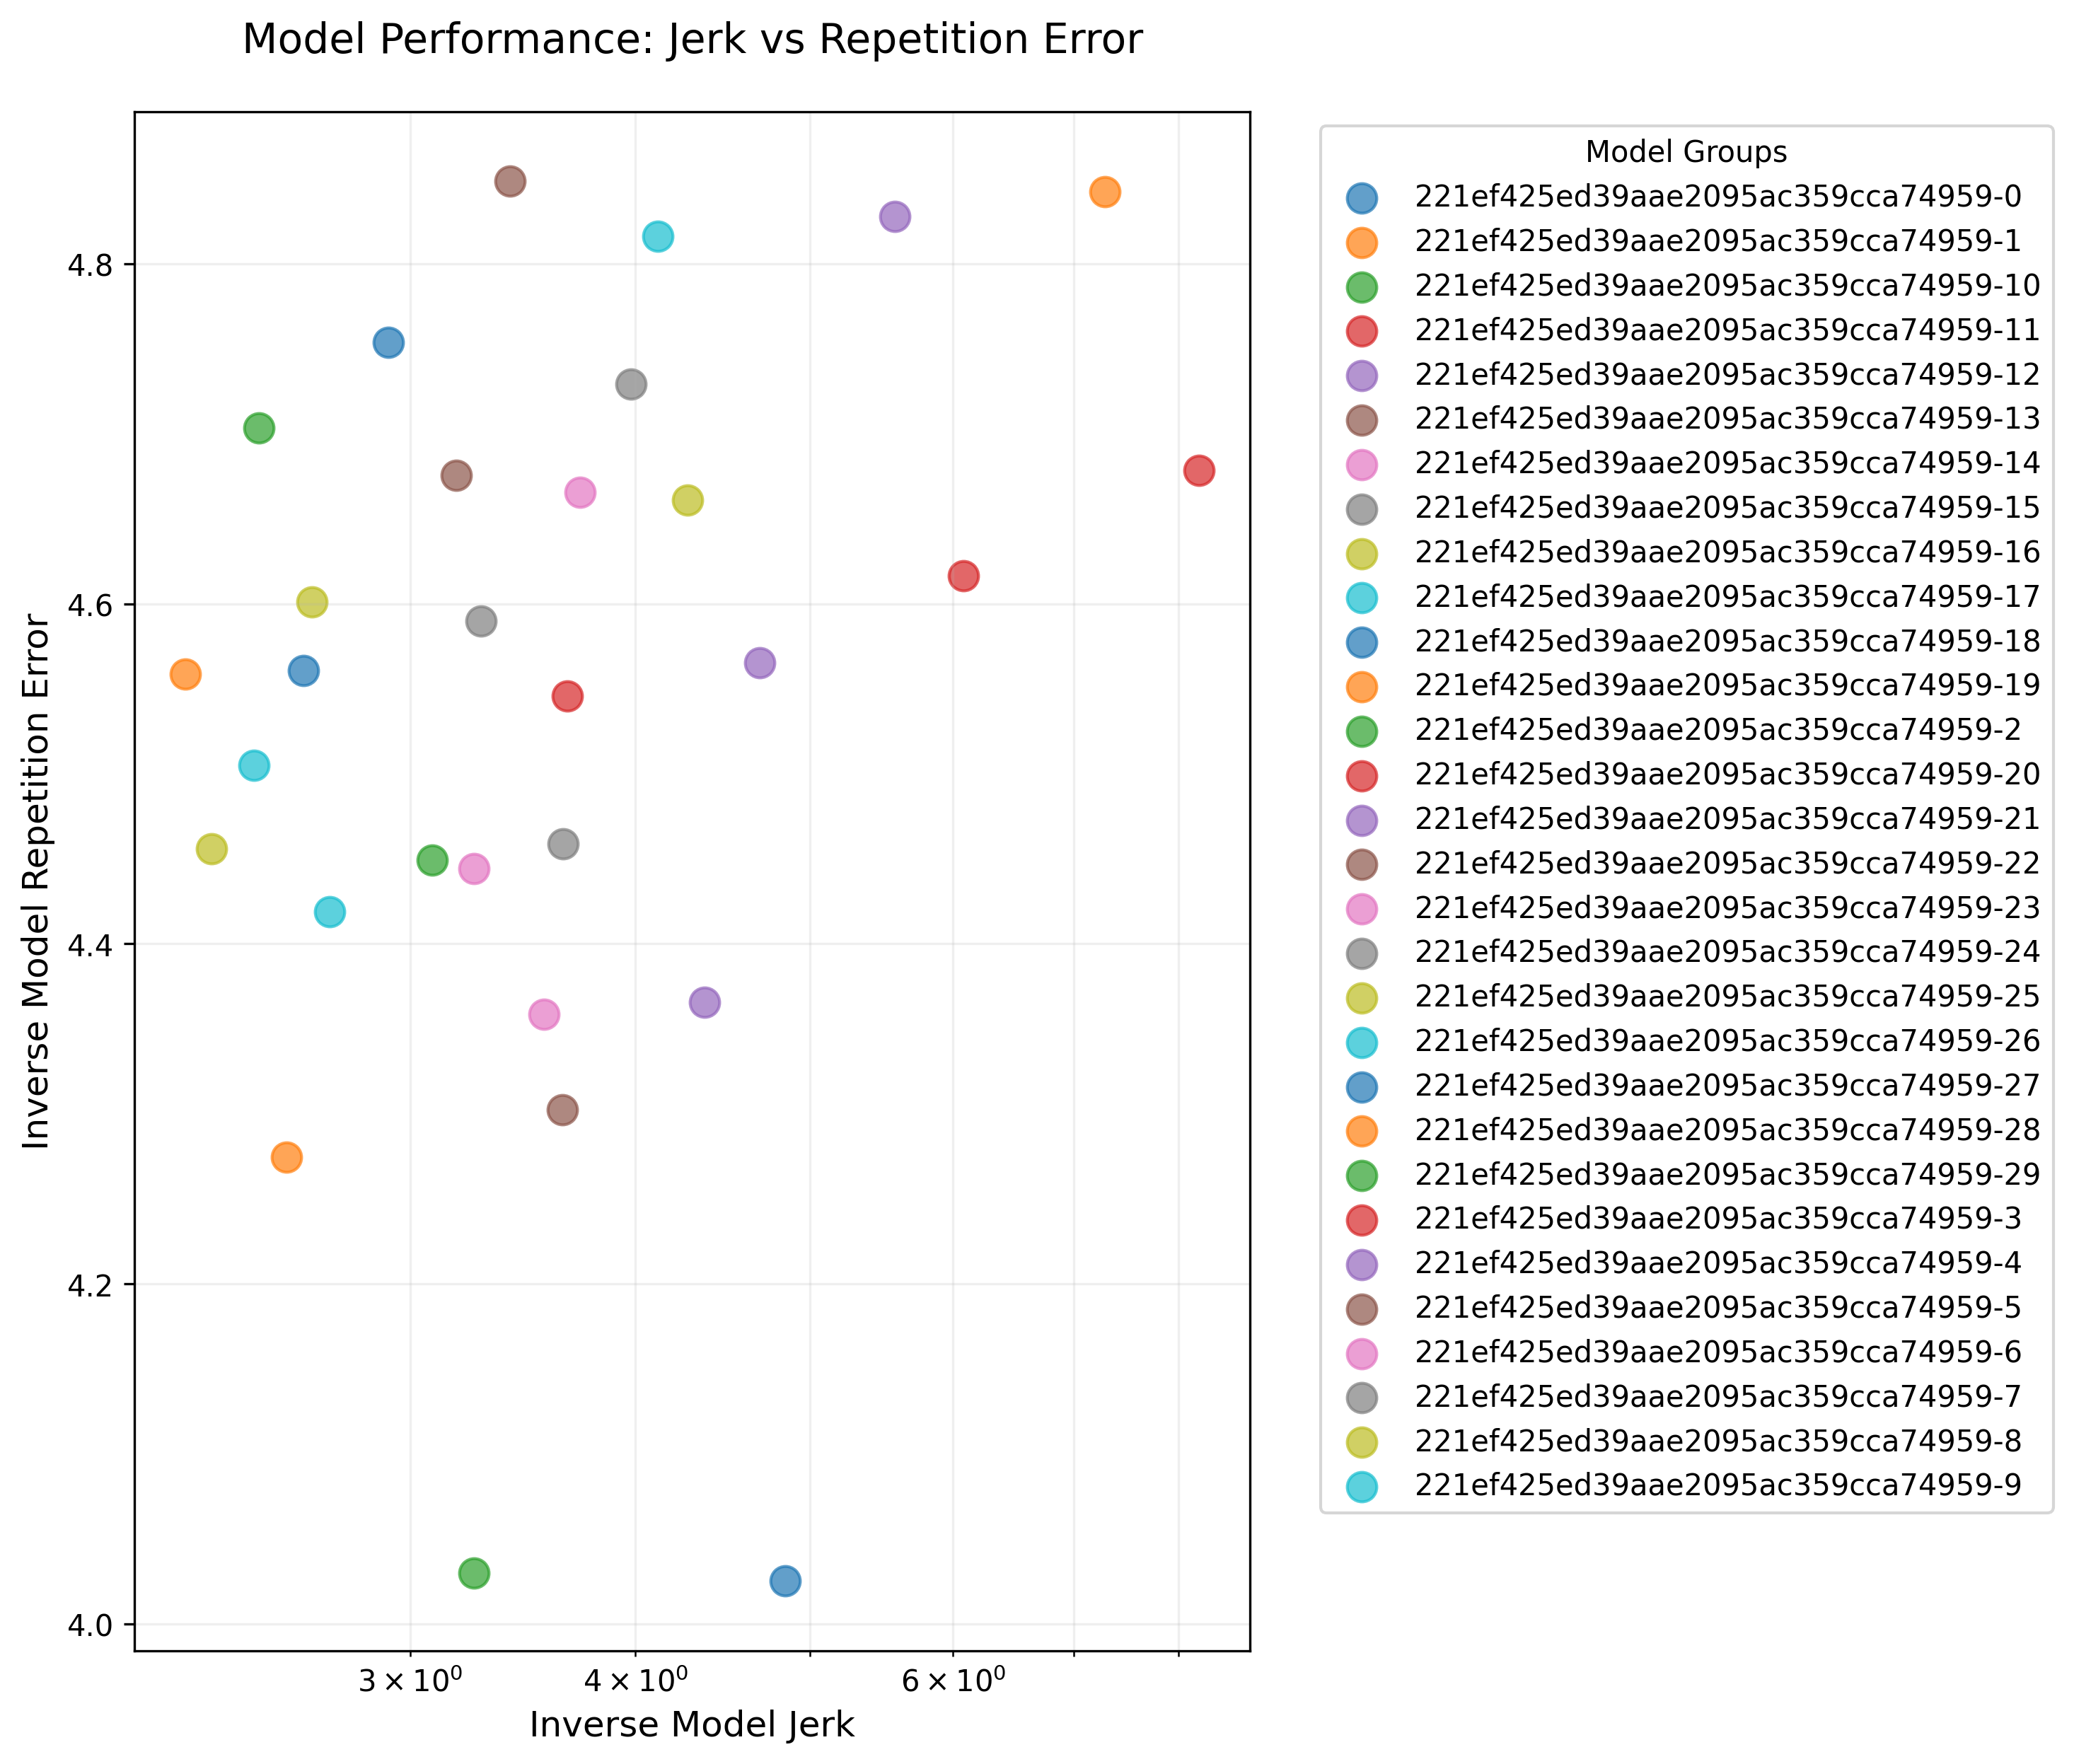

In [24]:
# Define metrics and scales for visualization
plot_metrics = ["inverse_model_jerk", "inverse_model_repetition_error"] 
plot_scales = ["log", "linear"]

# Create scatter plot comparing model performance metrics
plt.figure(figsize=(10, 8), dpi=300)  # Higher resolution
ax = plt.subplot()

# Configure axes with descriptive labels and appropriate scales
ax.set_xlabel(f"{plot_metrics[0].replace('_', ' ').title()}", fontsize=12)
ax.set_ylabel(f"{plot_metrics[1].replace('_', ' ').title()}", fontsize=12)
ax.set_xscale(plot_scales[0])
ax.set_yscale(plot_scales[1])

# Add grid for better readability
ax.grid(True, which="both", ls="-", alpha=0.2)

# Plot mean metrics for each model group
groups_name = groups_metrics[plot_metrics[0]].keys()
for group_name in groups_name:
    # Calculate mean performance metrics
    x = np.mean(groups_metrics[plot_metrics[0]][group_name])
    y = np.mean(groups_metrics[plot_metrics[1]][group_name])
    
    # Plot with enhanced styling
    ax.scatter(x, y, label=group_name.split('/')[-2], s=100, alpha=0.7)
    
    # Print metrics for analysis
    print(f"Group: {group_name.split('/')[-2]}")
    print(f"Mean {plot_metrics[0]}: {x:.4f}")
    print(f"Mean {plot_metrics[1]}: {y:.4f}\n")

# Customize legend and layout
ax.legend(title="Model Groups", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

# Add title describing the comparison
plt.title("Model Performance: Jerk vs Repetition Error", pad=20, fontsize=14)

plt.show()